In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import os
import cv2
import fnmatch
from copy import deepcopy as dc

from matplotlib.pyplot import Circle

In [2]:
def recursive_glob(rootdir='.', pattern='*'):
	matches = []
	for root, dirnames, filenames in os.walk(rootdir):
	    for filename in fnmatch.filter(filenames, pattern):
		    matches.append(os.path.join(root, filename))

	return matches

In [3]:
images = []
joints = []
bounding = []

In [4]:
pathToDataset="annotated_frames/"
for i in range(1,3):
    path = pathToDataset+"data_"+str(i)+"/"
    images_path = recursive_glob(path, "*_webcam_[0-9]*")
    for i in images_path:
        image = cv2.imread(i)
        images.append(image)

In [5]:
pathToDataset="projections_2d/"
for i in range(1,3):
    path = pathToDataset+"data_"+str(i)+"/"
    joints_path = recursive_glob(path, "*_jointsCam_[0-9]*")
    for i in joints_path:
        joint = open(i, "r")
        temp = np.zeros(shape=(21, 2), dtype=np.float32)
        for i, line in enumerate(joint):
            row = line.split()
            temp[i,:] = (row[1],row[2])
        joints.append(temp)
        joint.close()

In [6]:
pathToDataset="bounding_boxes/"
for i in range(1,3):
    path = pathToDataset+"data_"+str(i)+"/"
    bbox_path = recursive_glob(path, "*_bbox_[0-9]*")
    for i in bbox_path:
        bbox = open(i, "r")
        temp = []
        for line in bbox:
            row = line.split()
            temp.append(int(row[1]))
        bounding.append(temp)
        bbox.close()

In [31]:
cropped_images=[]
cropped_joints=dc(joints)
max_w = 0
max_h = 0

In [32]:
for i, im in enumerate(images):
    bb = bounding[i]
    x=bb[0]
    h=bb[2]-x
    y=bb[1]
    w=bb[3]-y
    cr=im[x:x+h, y:y+w, :]
    cropped_joints[i][:,0] = cropped_joints[i][:,0] - y
    cropped_joints[i][:,1] = cropped_joints[i][:,1] - x
    cropped_images.append(cr)

In [33]:
downsized_images = []
downsized_joints = dc(cropped_joints)
scale_percent = 50 # percent of original size

In [34]:
for i, im in enumerate(cropped_images):
    width = int(im.shape[1] * scale_percent / 100)
    height = int(im.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
    downsized_images.append(resized)
    if resized.shape[0]>max_h:
        max_h = resized.shape[0]
    if resized.shape[1]>max_w:
        max_w = resized.shape[1]
    downsized_joints[i] = downsized_joints[i]/2

In [39]:
padded_images = []
padded_joints = dc(downsized_joints)

In [40]:
ww = max_w
hh = max_h
for i, im in enumerate(downsized_images):
    ht, wd, cc= im.shape

    # create new image of desired size and color (red) for padding
    color = (255,0,0)
    result = np.full((hh,ww,cc), color, dtype=np.uint8)

    # compute center offset
    xx = (ww - wd) // 2
    yy = (hh - ht) // 2

    # copy img image into center of result image
    result[yy:yy+ht, xx:xx+wd] = im
    padded_images.append(result)
    
    padded_joints[i][:,0] = padded_joints[i][:,0] + xx
    padded_joints[i][:,1] = padded_joints[i][:,1] + yy

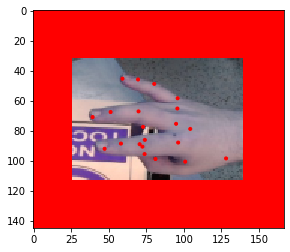

In [45]:
#check
t=4
j=dc(padded_joints[t])
bb=bounding[t]
im=padded_images[t]

fig, ax = plt.subplots(1)
ax.set_aspect('equal')

ax.imshow(im)

for xx, yy in j:
    circ = Circle((xx,yy),1,color='red')
    ax.add_patch(circ)

In [46]:
mydict = {'images':padded_images,'joints':padded_joints,'bounding':bounding}

In [47]:
with open('data_hand_pose.pickle','wb') as file_to_dump:
    pickle.dump(mydict,file_to_dump)